In [1]:
import cv2
import matplotlib.pyplot as plt
from  pathlib import Path

In [2]:
import pandas as pd
import numpy as np

In [3]:
def plotimg(img):
    plt.imshow(img)
    plt.show()
    return

In [4]:
df=pd.read_csv("data/Train/train.csv")
df.set_index("ImageId", inplace = True)
dn=df.values
classes_name=np.unique(dn[:,-1])
classes=classes_name.shape[0]
label_disc={}
for i in range(classes):
    label_disc.update({str(classes_name[i]):str(i)})
##till now i prepared label_discnary and classes(no of classes)
p=Path("data/Train/Images")
image_data=[]
labels=[]
for img_path in list(p.glob('*.jpg')):
    img_name=str(img_path).split('\\')[-1]
    img=cv2.imread(str(img_path),cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(40,40))
    #print(img.shape)
    image_data.append(img)
    labels.append(int(label_disc[df.loc[img_name][0]]))


In [5]:
image_data=np.array(image_data)
labels=np.array(labels)
M=image_data.shape[0]
image_data=image_data.reshape(M,-1)  

In [6]:
#####my old svm function
import numpy as np
class SVM:
    def __init__(self,C):
        self.C=C
        self.W=0
        self.B=0
    def hingeloss(self,w,b,X,Y):
        loss=0
        loss+=0.5*np.dot(w,w.T)
        for i in range(X.shape[0]):
            ti=Y[i]*(np.dot(w,X[i].T)+b)
            loss+=self.C*(max(0,1-ti))
        return loss[0][0]
    ##my hinge loss function is ready!
    def fit(self,X,Y,batch_size=100,lr=0.001,maxItr=500):
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        n=lr
        c=self.C
        w=np.zeros((1,no_of_features))
        bias=0
        losses=[]
        for i in range(maxItr):
            l=self.hingeloss(w,bias,X,Y)
            losses.append(l)
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            for batch_start in range(0,no_of_samples,batch_size):
                gradw=0;
                gradb=0;
                for j in range(batch_start,batch_start+batch_size):
                    if j < no_of_samples:
                        i=ids[j]
                        ti=Y[i]*(np.dot(w,X[i].T)+bias)
                        if ti>1:
                            gradw+=0;
                            gradb+=0
                        else:
                            gradw+=c*Y[i]*X[i]
                            gradb+=c*Y[i]
                w=w-n*w+n*gradw;
                bias=bias+n*gradb
        self.w=w
        self.b=bias
        return w,bias,losses
   

In [7]:
### function to get data for pair of classes need by our one vs one algo
M=image_data.shape[0]
image_data=image_data.reshape(M,-1)
classes=np.unique(labels).shape[0]
def getdatapairsvm(d1,d2): 
    l1,l2=d1.shape[0],d2.shape[0]
    samples=l1+l2
    features=d1.shape[1]
    data_pair=np.zeros((samples,features))
    data_labels=np.zeros((samples,))
    data_pair[:l1]=d1
    data_pair[l1:]=d2
    data_labels[:l1]=-1
    data_labels[l1:]=+1
    return data_pair,data_labels

In [8]:
#function to get data in the form like data[i]=all images for label 1 since we need it for pair of images part
def classwisedata(X,Y):
    data=[None] * classes
    for i in range(classes):
        data[i]=[]
    for i in range(X.shape[0]):
        data[int(Y[i])].append(X[i])
    for k in range(classes):
        data[k]=np.array(data[k])
        
    return np.array(data)
data=classwisedata(image_data,labels)


C:\Users\kip31\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [9]:
def trainsvm(X,Y):
    svm_classifier=[None] * classes
    for i in range(classes):
        svm_classifier[i]={}
        for j in range(i+1,classes):
            x_pair,y_pair=getdatapairsvm(data[i],data[j])
            w,b,loss=mySVM.fit(x_pair,y_pair,int(50),0.0000001,1000)
            plt.plot(loss)
            #print(loss)
            plt.show()
            svm_classifier[i][j]=(w,b)
    return svm_classifier


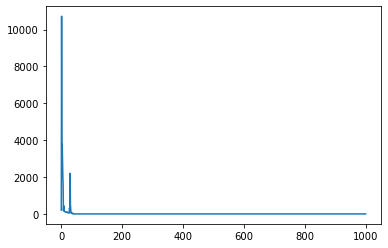

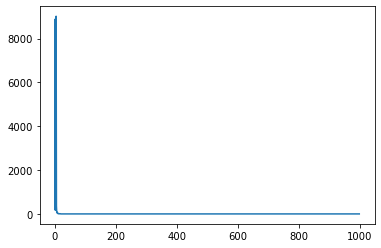

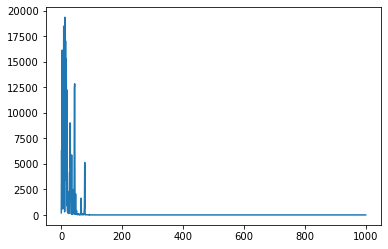

In [10]:
mySVM=SVM(1.0)    
svm_classifier=trainsvm(image_data,labels)

In [11]:
def binary_predict(x,w,b):
    
    z=np.dot(x,w.T)+b
    if(z>=0):
        return 1
    else:
        return -1
    

In [12]:
def predict(x):
    count=np.zeros((classes,))
    for i in range(classes):
        for j in range(i+1,classes):
            w,b=svm_classifier[i][j]
            
            z=binary_predict(x,w,b)
            if(z==1):
                count[j]+=1
            else:
                count[i]+=1
    final_pred=np.argmax(count)
    return final_pred

    

In [13]:
def acc(x,y):
    count=0
    for i in range(x.shape[0]):
        pred=predict(x[i])
        
        if pred==int(y[i]):
            count+=1
        #print('pridiction ',appo[str(pred)]," and real is ",appo[str(y[i])])    
    return count/x.shape[0]
acc(image_data,labels)

1.0

In [14]:
image_test_data=[]
img_names=[]
p=Path("data/Test/Images")
for img_path in list(p.glob('*.jpg')):
    img_name=str(img_path).split('\\')[-1]
    img=cv2.imread(str(img_path),cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(40,40))
    img=np.array(img)
    if len(img.shape)<3:
        t=np.zeros((img.shape[0],img.shape[0],3))
        t[:,:,0]=img[:,:]
        t[:,:,1]=img[:,:]
        t[:,:,2]=img[:,:]
        img=t
    img=list(img)   
    image_test_data.append(img)
    img_names.append(img_name)
#cv2.imshow('image',img)
#img=np.array(img)
#img.shape

In [15]:
image_test_data=np.array(image_test_data)
img_names=np.array(img_names)
M=image_test_data.shape[0]
image_test_data=image_test_data.reshape(M,-1)  

In [37]:
index_to_names={}
for i in range(classes):
    index_to_names.update({str(i):str(classes_name[i])})  

def predictcsv(x,y):
    disc={}    
    for i in range(x.shape[0]):
        pred=predict(x[i])
        pred=str(pred)
      
        disc.update({str(y[i]):str(index_to_names[pred])})
    return disc
disc=predictcsv(image_test_data,img_names)       


In [40]:
df=pd.read_csv('data/Test/test.csv')
nd=df.values

In [49]:
header='ImageId,NameOfPokemon\n'
with open('mynew.csv','w+') as file:
    file.write(header)
    for i in nd:
        file.write(i[0])
        file.write(',')
        file.write(disc[i[0]])
        file.write('\n')
        

In [56]:
dp=pd.read_csv('mynew.csv')

In [57]:
dp.head()

,ImageId,NameOfPokemon
0,1106.jpg,Bulbasaur
1,2236.jpg,Charmander
2,1131.jpg,Bulbasaur
3,2221.jpg,Charmander
4,2011.jpg,Pikachu


array([['1106.jpg', 'Bulbasaur'],
       ['2236.jpg', 'Charmander'],
       ['1131.jpg', 'Bulbasaur'],
       ['2221.jpg', 'Charmander'],
       ['2011.jpg', 'Pikachu'],
       ['2030.jpg', 'Pikachu'],
       ['2035.jpg', 'Pikachu'],
       ['1110.jpg', 'Bulbasaur'],
       ['1104.jpg', 'Bulbasaur'],
       ['2217.jpg', 'Charmander'],
       ['1111.jpg', 'Bulbasaur'],
       ['1100.jpg', 'Bulbasaur'],
       ['1112.jpg', 'Bulbasaur'],
       ['1138.jpg', 'Bulbasaur'],
       ['2238.jpg', 'Charmander'],
       ['2009.jpg', 'Bulbasaur'],
       ['2225.jpg', 'Charmander'],
       ['2240.jpg', 'Charmander'],
       ['2020.jpg', 'Pikachu'],
       ['2209.jpg', 'Charmander'],
       ['2029.jpg', 'Pikachu'],
       ['1114.jpg', 'Bulbasaur'],
       ['2201.jpg', 'Charmander'],
       ['1118.jpg', 'Bulbasaur'],
       ['2025.jpg', 'Pikachu'],
       ['2202.jpg', 'Charmander'],
       ['1117.jpg', 'Bulbasaur'],
       ['1119.jpg', 'Bulbasaur'],
       ['2000.jpg', 'Pikachu'],
       ['2007.jpg',